In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random
import math
import copy
import io
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D

import torch
import torchvision
import torch
import torch.nn as nn
from torch import cuda
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.mps as mps



if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

print(f"Using device: {device}")

import sys
sys.path.append('models_scratch/')
sys.path.append('data/')
from models_scratch import *
from data_utils import *

%matplotlib inline
sns.set(style="whitegrid")

Using device: cuda


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D

def plot_metrics_by_imbalance(df, network, kappa, show_test=False, show_loss=False):
    n_epochs = int(df["epoch"].max())
    pdf_path = f"results/CIFAR-10/figures/{network}_metrics_by_imbalance_kappa_{kappa}_{'with_test' if show_test else 'train_only'}.pdf"

    df_loss_train = df.melt(id_vars=["num_run", "epoch", "time", "imbalance"],
                            value_vars=["train_loss_all", "train_loss_s0", "train_loss_s1"],
                            var_name="group", value_name="train_loss")
    df_acc_train = df.melt(id_vars=["num_run", "epoch", "time", "imbalance"],
                           value_vars=["train_acc_all", "train_acc_s0", "train_acc_s1"],
                           var_name="group", value_name="train_acc")

    df_loss_test, df_acc_test = None, None
    if show_test:
        df_loss_test = df.melt(id_vars=["num_run", "epoch", "time", "imbalance"],
                               value_vars=["test_loss_all", "test_loss_s0", "test_loss_s1"],
                               var_name="group", value_name="test_loss")
        df_acc_test = df.melt(id_vars=["num_run", "epoch", "time", "imbalance"],
                              value_vars=["test_acc_all", "test_acc_s0", "test_acc_s1"],
                              var_name="group", value_name="test_acc")

    mapping = {
        "train_loss_all": "Global", "train_loss_s0": "A=0", "train_loss_s1": "A=1",
        "test_loss_all": "Global", "test_loss_s0": "A=0", "test_loss_s1": "A=1",
        "train_acc_all": "Global", "train_acc_s0": "A=0", "train_acc_s1": "A=1",
        "test_acc_all": "Global", "test_acc_s0": "A=0", "test_acc_s1": "A=1"
    }

    df_loss_train["group"] = df_loss_train["group"].map(mapping)
    df_acc_train["group"] = df_acc_train["group"].map(mapping)
    if show_test:
        df_loss_test["group"] = df_loss_test["group"].map(mapping)
        df_acc_test["group"] = df_acc_test["group"].map(mapping)

    palette = {"A=0": "blue", "A=1": "orange", "Global": "green"}
    imbalance_levels = sorted(df["imbalance"].unique())
    n_cols = len(imbalance_levels)
    n_rows = 4 if show_test and show_loss else 2 if show_loss or show_test else 1

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 3.75 * n_rows))
    if n_rows == 1:
        axes = np.expand_dims(axes, axis=0)
    elif n_cols == 1:
        axes = axes.reshape(n_rows, 1)

    def plot_metric(ax, data, y_value, log_scale=False):
        sns.lineplot(data=data, x="epoch", y=y_value, hue="group",
                     estimator="mean", errorbar="sd", palette=palette, ax=ax, legend=False)
        if log_scale:
            ax.set_yscale('log')
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    for col_idx, imbalance in enumerate(imbalance_levels):
        row_idx = 0
        if show_loss:
            plot_metric(axes[row_idx, col_idx], df_loss_train[df_loss_train["imbalance"] == imbalance], "train_loss", log_scale=True)
            axes[row_idx, col_idx].set_title(rf"$\zeta = {imbalance}\%$", fontsize=14)
            axes[row_idx, 0].set_ylabel("Train loss", fontsize=14)
            row_idx += 1
        else:
            axes[row_idx, col_idx].set_title(rf"$\zeta = {imbalance}\%$", fontsize=14)

        plot_metric(axes[row_idx, col_idx], df_acc_train[df_acc_train["imbalance"] == imbalance], "train_acc")
        axes[row_idx, col_idx].axhline(kappa, color='red', linestyle='--', linewidth=1)
        if col_idx == 0:
            axes[row_idx, 0].set_ylabel("Train accuracy (%)", fontsize=14)
        row_idx += 1

        if show_test:
            if show_loss:
                plot_metric(axes[row_idx, col_idx], df_loss_test[df_loss_test["imbalance"] == imbalance], "test_loss", log_scale=True)
                axes[row_idx, 0].set_ylabel("Test loss", fontsize=12)
                row_idx += 1

            plot_metric(axes[row_idx, col_idx], df_acc_test[df_acc_test["imbalance"] == imbalance], "test_acc")
            axes[row_idx, 0].set_ylabel("Test accuracy (%)", fontsize=12)
            axes[row_idx, col_idx].set_xlabel("Epoch")

    for row in range(n_rows):
        for col in range(1, n_cols):
            axes[row, col].set_ylabel("")
        for col in range(n_cols):
            if row < (n_rows - 1):
                axes[row, col].set_xlabel("")

    group_legend = [Line2D([0], [0], color=color, lw=2, label=label)
                    for label, color in palette.items()]
    red_line = Line2D([0], [0], color='red', lw=1, linestyle='--', label=r"$\kappa$ threshold")

    # Légende en bas
    fig.legend(group_legend + [red_line], [*palette.keys(), r"$\kappa$ threshold"],
               loc="lower center", ncol=4, fontsize=14, bbox_to_anchor=(0.5, -0.05))

    # Ajustement de l'espace pour laisser place à la légende en bas
    plt.tight_layout(rect=[0, 0.07, 1, 1])
    plt.savefig(pdf_path, bbox_inches="tight")
    plt.show()

In [12]:
df_results =  pd.read_csv("results/CIFAR-10/epochs/resnet18_per_epoch_results_kappa_90.0.csv")

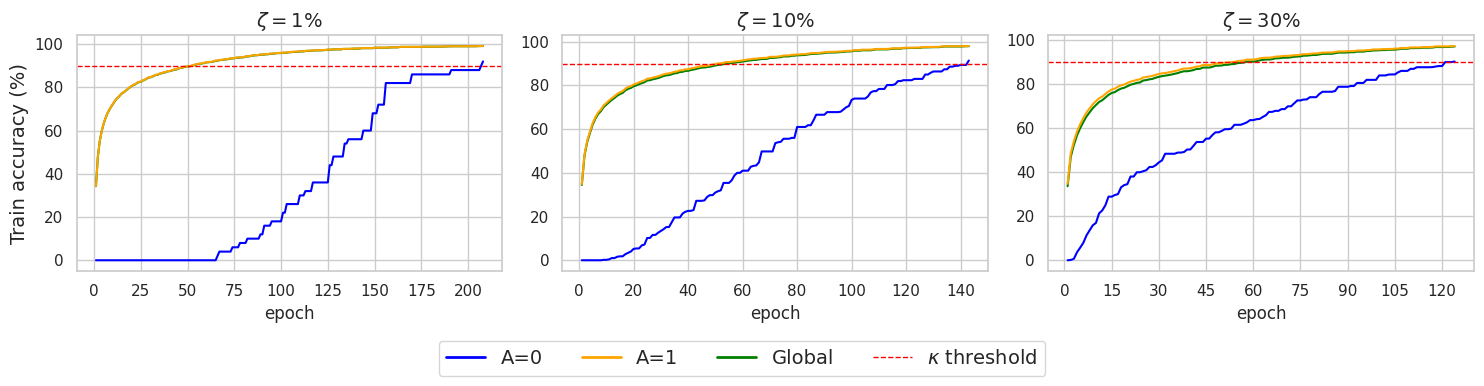

In [13]:
plot_metrics_by_imbalance(df_results, 'resnet18', 90.0, show_test=False, show_loss=False)